# Make a software package for generating train/test data

# Add resampling, and fix all the timescales

+ Utilities for combining models / directional forcing
+ Sample at same rate
+ Easily integrate ensembles of trajectories

In [103]:
from private.lyap import *
def delay_embedding(data, emb_dim, lag=1):
  data = np.asarray(data)
  min_len = (emb_dim - 1) * lag + 1
  if len(data) < min_len:
    msg = "cannot embed data of length {} with embedding dimension {} " \
        + "and lag {}, minimum required length is {}"
    raise ValueError(msg.format(len(data), emb_dim, lag, min_len))
  m = len(data) - min_len + 1
  indices = np.repeat([np.arange(emb_dim) * lag], m, axis=0)
  indices += np.arange(m).reshape((m, 1))
  return data[indices]
def lyap_e2(data, emb_dim=10, matrix_dim=4, min_nb=None, min_tsep=0, tau=1,
           debug_plot=False, debug_data=False, plot_file=None):
  data = np.asarray(data)
  n = len(data)
  if (emb_dim - 1) % (matrix_dim - 1) != 0:
    raise ValueError("emb_dim - 1 must be divisible by matrix_dim - 1!")
  m = (emb_dim - 1) // (matrix_dim - 1)
  if min_nb is None:
    # minimal number of neighbors as suggested by Eckmann et al.
    min_nb = min(2 * matrix_dim, matrix_dim + 4)

  min_len = lyap_e_len(
    emb_dim=emb_dim, matrix_dim=matrix_dim, min_nb=min_nb, min_tsep=min_tsep
  )
  if n < min_len:
    msg = "{} data points are not enough! For emb_dim = {}, matrix_dim = {}, " \
      + "min_tsep = {} and min_nb = {} you need at least {} data points " \
      + "in your time series"
    warnings.warn(
      msg.format(n, emb_dim, matrix_dim, min_tsep, min_nb, min_len),
      RuntimeWarning
    )

  # construct orbit as matrix (e = emb_dim)
  # x0 x1 x2 ... xe-1
  # x1 x2 x3 ... xe
  # x2 x3 x4 ... xe+1
  # ...

  # note: we need to be able to step m points further for the beta vector
  #       => maximum start index is n - emb_dim - m
  orbit = delay_embedding(data[:-m], emb_dim, lag=1)
  if len(orbit) < min_nb:
    assert len(data) < min_len
    msg = "Not enough data points. Need at least {} additional data points " \
        + "to have min_nb = {} neighbor candidates"
    raise ValueError(msg.format(min_nb-len(orbit), min_nb))
  old_Q = np.identity(matrix_dim)
  lexp = np.zeros(matrix_dim, dtype="float32")
  lexp_counts = np.zeros(lexp.shape)
  debug_values = []
  # TODO reduce number of points to visit?
  # TODO performance test!
  for i in range(len(orbit)):
    # find neighbors for each vector in the orbit using the chebyshev distance
    diffs = rowwise_chebyshev(orbit, orbit[i])
    # ensure that we do not count the difference of the vector to itself
    diffs[i] = float('inf')
    # mask all neighbors that are too close in time to the vector itself
    mask_from = max(0, i - min_tsep)
    mask_to = min(len(diffs), i + min_tsep + 1)
    diffs[mask_from:mask_to] = np.inf
    indices = np.argsort(diffs)
    idx = indices[min_nb - 1]  # index of the min_nb-nearest neighbor
    r = diffs[idx]    # corresponding distance
    if np.isinf(r):
      assert len(data) < min_len
      msg = "Not enough data points. Orbit vector {} has less than min_nb = " \
          + "{} valid neighbors that are at least min_tsep = {} time steps " \
          + "away. Input must have at least length {}."
      raise ValueError(msg.format(i, min_nb, min_tsep, min_len))
    # there may be more than min_nb vectors at distance r (if multiple vectors
    # have a distance of exactly r)
    # => update index accordingly
    indices = np.where(diffs <= r)[0]
    print(indices)
    # find the matrix T_i that satisifies
    # T_i (orbit'[j] - orbit'[i]) = (orbit'[j+m] - orbit'[i+m])
    # for all neighbors j where orbit'[i] = [x[i], x[i+m],
    # ... x[i + (matrix_dim-1)*m]]

    # note that T_i has the following form:
    # 0  1  0  ... 0
    # 0  0  1  ... 0
    # ...
    # a0 a1 a2 ... a(matrix_dim-1)

    # This is because for all rows except the last one the aforementioned
    # equation has a clear solution since orbit'[j+m] - orbit'[i+m] =
    # [x[j+m]-x[i+m], x[j+2*m]-x[i+2*m], ... x[j+d_M*m]-x[i+d_M*m]]
    # and
    # orbit'[j] - orbit'[i] =
    # [x[j]-x[i], x[j+m]-x[i+m], ... x[j+(d_M-1)*m]-x[i+(d_M-1)*m]]
    # therefore x[j+k*m] - x[i+k*m] is already contained in
    # orbit'[j] - orbit'[x] for all k from 1 to matrix_dim-1. Only for
    # k = matrix_dim there is an actual problem to solve.

    # We can therefore find a = [a0, a1, a2, ... a(matrix_dim-1)] by
    # formulating a linear least squares problem (mat_X * a = vec_beta)
    # as follows.

    # build matrix X for linear least squares (d_M = matrix_dim)
    # x_j1 - x_i   x_j1+m - x_i+m   ...   x_j1+(d_M-1)m - x_i+(d_M-1)m
    # x_j2 - x_i   x_j2+m - x_i+m   ...   x_j2+(d_M-1)m - x_i+(d_M-1)m
    # ...

    # note: emb_dim = (d_M - 1) * m + 1
    mat_X = np.array([data[j:j + emb_dim:m] for j in indices[:6]])
    mat_X -= data[i:i + emb_dim:m]
    # build vector beta for linear least squares
    # x_j1+(d_M)m - x_i+(d_M)m
    # x_j2+(d_M)m - x_i+(d_M)m
    # ...
    if max(np.max(indices),i) + matrix_dim * m >= len(data):
      assert len(data) < min_len
      msg = "Not enough data points. Cannot follow orbit vector {} for " \
          + "{} (matrix_dim * m) time steps. Input must have at least length " \
          + "{}."
      raise ValueError(msg.format(i, matrix_dim * m, min_len))
    vec_beta = data[indices + matrix_dim * m] - data[i + matrix_dim * m]
    # perform linear least squares
    a, _, _, _ = np.linalg.lstsq(mat_X, vec_beta, rcond=-1)
    print(a.shape)
    # build matrix T
    # 0  1  0  ... 0
    # 0  0  1  ... 0
    # ...
    # 0  0  0  ... 1
    # a1 a2 a3 ... a_(d_M)
    mat_T = np.zeros((matrix_dim, matrix_dim))
    mat_T[:-1, 1:] = np.identity(matrix_dim - 1)
    mat_T[-1] = a

    # QR-decomposition of T * old_Q
    mat_Q, mat_R = np.linalg.qr(np.dot(mat_T, old_Q))
    # force diagonal of R to be positive
    # (if QR = A then also QLL'R = A with L' = L^-1)
    sign_diag = np.sign(np.diag(mat_R))
    sign_diag[np.where(sign_diag == 0)] = 1
    sign_diag = np.diag(sign_diag)
    mat_Q = np.dot(mat_Q, sign_diag)
    mat_R = np.dot(sign_diag, mat_R)

    old_Q = mat_Q
    # successively build sum for Lyapunov exponents
    diag_R = np.diag(mat_R)
    # filter zeros in mat_R (would lead to -infs)
    idx = np.where(diag_R > 0)
    lexp_i = np.zeros(diag_R.shape, dtype="float32")
    lexp_i[idx] = np.log(diag_R[idx])
    lexp_i[np.where(diag_R == 0)] = np.inf
    if debug_plot or debug_data:
      debug_values.append(lexp_i / tau / m)
    lexp[idx] += lexp_i[idx]
    lexp_counts[idx] += 1
  # end of loop over orbit vectors
  # it may happen that all R-matrices contained zeros => exponent really has
  # to be -inf
  if debug_plot:
    plot_histogram_matrix(np.array(debug_values), "layp_e", fname=plot_file)
  # normalize exponents over number of individual mat_Rs
  idx = np.where(lexp_counts > 0)
  lexp[idx] /= lexp_counts[idx]
  lexp[np.where(lexp_counts == 0)] = np.inf
  # normalize with respect to tau
  lexp /= tau
  # take m into account
  lexp /= m
  if debug_data:
    return (lexp, np.array(debug_values))
  return lexp

In [128]:
np.linalg.lstsq(np.random.random((5, 2)), np.random.random((5, 2)))

<ipython-input-128-92ad1614bc95>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(np.random.random((5, 2)), np.random.random((5, 2)))


(array([[0.44519043, 0.71736669],
        [0.43903014, 0.15221093]]),
 array([0.11015891, 0.18640877]),
 2,
 array([2.15772198, 0.49261822]))

In [1]:
%%bash 
pip install -I .

Processing /Users/williamgilpin/program_repos/thom
  Created wheel for thom: filename=thom-0.0.0-py3-none-any.whl size=36701 sha256=1c7757a2cd53631ab96345fbb5656b98676cc50a392ddf8c8346b88ccf549a4c
  Stored in directory: /private/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/pip-ephem-wheel-cache-lhoyw1f0/wheels/e7/a3/3b/b00bb9a6e6623759d442a2bb7ef13359cce81732ea665222f0
Successfully built thom


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [2]:
import sys

import matplotlib.pyplot as plt

from thom import *
from thom.base import *
from thom.utils import *

from private.lyap import lyap_r, lyap_e, corr_dim

%load_ext autoreload
%autoreload 2

In [199]:
model = Lorenz() # λ1 = 2.0686, λ2 = −0.0115, λ3 = −32.3537, dim ~ 2
model.sigma = 16
model.rho = 45.92
model.beta = 4.0
# model.dt =1e-3

# model = Rossler() # λ1 = 0.13, λ2 = 0, λ3 = −14.1, dim ~ 2
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# # model.dt = 1e-2

tpts, sol = model.make_trajectory(10000, resample=True, pts_per_period=300, return_times=True)
dt = np.median(np.diff(tpts))
print(lyap_r(sol.T, tau=dt), corr_dim(sol.T))




/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


1.905062030809844 2.0052564617847226


In [206]:
model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
model.a = 0.15
model.b = 0.2
model.c = 10
model.dt =1e-2

model.ic = np.array([  4.66009155, -12.12441564,   0.29234687])


tpts, sol = model.make_trajectory(10000, resample=True, pts_per_period=150, return_times=True)

array([-0.31972524, -1.07704777, 28.19067404])

array([[-16.        ,  16.        ,   0.        ],
       [ 17.72932596,  -1.        ,   0.31972524],
       [ -1.07704777,  -0.31972524,  -4.        ]])

In [133]:
model = Lorenz()

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[1]), 100, replace=False)
sample_pts = initial_sol[:, sample_inds].T

model.ic = sample_pts

tpts, sol = model.make_trajectory(1000, resample=True, pts_per_period=30, return_times=True)
dt = np.median(np.diff(tpts))

KeyboardInterrupt: 

In [123]:
1.4179114942095334
1.9400765475861061

1.4155669923225198


In [126]:
all_estimates_lyap = [lyap_r(item, tau=dt) for item in sol]
all_estimates_corr = [corr_dim(item) for item in sol]

print(np.median(all_estimates_lyap))
print(np.median(all_estimates_corr))

/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/ly

1.3612105696228687
1.9364653042686115


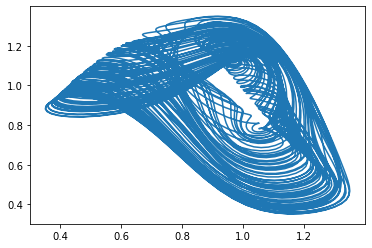

In [5]:
eq = MackeyGlass()

sol = eq.make_trajectory(5000, resample=True)
# eq.ic = np.vstack([eq.ic, eq.ic])

# plt.plot(sol[0], sol[1], '.k', markersize=.1)
plt.plot(sol[0], sol[1])
# plt.plot(sol[0][:50000], sol[1][:50000])

## Make Lorenz Ensemble for classification

# Finding Lyapunov exponents

In [310]:
model.b

0.2

In [305]:
np.median(np.array(lyap_list), axis=0)

array([-4.59650544,  0.06752232,  0.15855425])

In [300]:
model =  Rossler()
model.a = 0.15
model.c = 10
print([model.a, model.b, model.c])

# a = 0.15, b = 0.20, c = 10

[0.15, 0.2, 10]


In [301]:
model =  Rossler()
model.a = 0.15
model.c = 10

sol = model.make_trajectory(8000, method="Radau", resample=True, pts_per_period=300)
plt.plot(sol[1], sol[2])

In [87]:
np.sort(lexp)

array([3.38248042e-08, 3.52673735e-08, 1.13320694e-07])

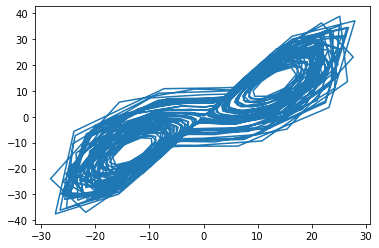

In [104]:
plt.plot(initial_sol[0], initial_sol[1])

In [2]:
model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
model.sigma = 16
model.rho = 45.92
model.beta = 4.0

# model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# model.dt = 1e-3

points_to_sample = 20
m = 5 # number of timesteps to use to find the jacobian

lyap_list = list()

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), points_to_sample, replace=False)
sample_pts = initial_sol[:, sample_inds].T
(d, _) = initial_sol.shape
print("Finished selecting initial points on attractor.")

all_estimates_lyap = list()
for i, sample_pt in enumerate(sample_pts):
    if i % 5 == 0: print(i)
    model.ic = sample_pt
    model.ic = make_epsilon_ball(model.ic, 400).T
    tpts, traj_ball = model.make_trajectory(m, resample=True, pts_per_period=30, return_times=True)
    dt = np.median(np.diff(tpts))
    
    traj_ball -= np.mean(traj_ball, axis=0, keepdims=True)

    cov = np.einsum("kim,kin->imn", traj_ball, traj_ball) / (traj_ball.shape[0] - 1)
    eigs, vecs = np.linalg.eigh(cov)
    rads = np.sqrt(eigs)
    rads /= rads[0, :][None, :]

    assert np.all(np.diff(np.argsort(eigs, axis=1), axis=1) == 1), "Eigenvalues are not sorted; please report this bug."

    xinds = np.tile(np.arange(eigs.shape[0]), (eigs.shape[1], 1))

    # rads = np.sqrt(np.sum((traj_ball[[1, 2, 9]] - traj_ball[[3, 4, 8]])**2, axis=-1).T)
    # rads /= rads[0, :][None, :]

    
    all_lyap = find_slope(xinds, np.log(rads.T)) / dt

    print(all_lyap)
    
    lyap_list.append(all_lyap)
    
print("\nFinal estimate: ", np.median(np.array(lyap_list), axis=0)[::-1])    




Finished selecting initial points on attractor.
0


NameError: name 'make_epsilon_ball' is not defined

In [243]:
tpts, traj_ball = model.make_trajectory(pts_per_trajectory, pts_per_period=100, 
                                        resample=True, return_times=True)

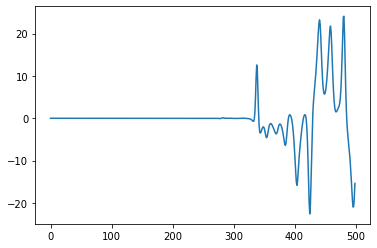

In [240]:
plt.plot(traj_ball[0, :, 0])

In [248]:
model.dt

0.0001801

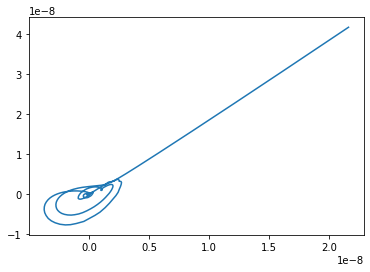

In [246]:
plt.plot(traj_ball[0, :, 0], traj_ball[0, :, 1])

In [284]:
model.make_trajectory(2, resample=False).T

array([[15.33969566,  9.42871966, 53.77028496],
       [15.32265347,  9.40536543, 53.75755523]])

In [283]:
model.make_trajectory(2, resample=False)[:, -1]

array([15.32265347,  9.40536543, 53.75755523])

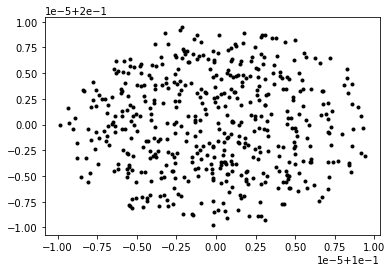

In [291]:
ee = make_epsilon_ball([0.1, 0.2, 0.3], 500)
plt.plot(ee[0], ee[1], '.k')

In [311]:
np.mean(x, axis=0)

array([89.83876126, 98.01364199, 59.86290173])

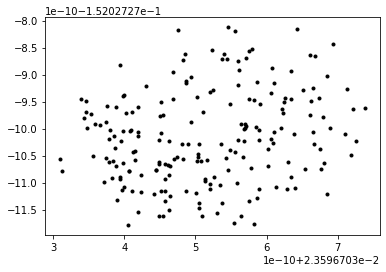

In [305]:
x = make_epsilon_ball(curr, pts_to_estimate_jacobian, eps=1e-8).T
y = np.vstack(model.rhs(x, 0)).T * model.dt

plt.plot(y[:, 0], y[:, 1], '.k')

In [339]:
# np.dot(tm.T, x.T) - y.T

In [357]:

curr

array([-10.74387579, -17.43743062,  21.36186538])

In [359]:
np.mean(y0, axis=0)

array([-1.07096877, -2.46412117,  1.01898127])

In [362]:
x0 = make_epsilon_ball(curr, pts_to_estimate_jacobian, eps=1e-8).T
y0 = x0 + np.vstack(model.rhs(x0, 0)).T * model.dt
x = x0 - np.mean(x0, axis=0)
y = y0 - np.mean(y0, axis=0)
curr = model.make_trajectory(2, resample=False)[:, -1]


xinv = np.linalg.pinv(x.T)
tm = np.dot(y.T, xinv)

In [432]:
final_lyap

array([  1.2624195 ,   0.81332448, -16.68214539])

In [446]:
all_estimates_lyap = np.array([])
np.vstack([[all_estimates_lyap], [final_lyap], [final_lyap]])


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 3

In [529]:
NUMBA_DISABLE_JIT

In [535]:
sample_pts.shape

(10, 3)

In [3]:
from thom.analysis import sample_initial_conditions, find_lyapunov_exponents

model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
# model.sigma = 16
# model.rho = 45.92
# model.beta = 4.0
# model.dt = 1e-4


# model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
# model.dt = 1e-2
# model.dt = 1e-4

# model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# model.dt = 1e-3




points_to_sample = 10 # number of points to sample in ensemble
sample_pts = sample_initial_conditions(model, points_to_sample)
print("Finished selecting initial points on attractor.")

pts_per_trajectory = 5000 # number of timesteps to use to find the jacobian
model.dt /= 10

lyap_list = list()

all_estimates_lyap = list()
for j, sample_pt in enumerate(sample_pts):
    if j % 5 == 0: print(j)
    model.ic = sample_pt
    all_estimates_lyap.append(find_lyapunov_exponents(model, pts_per_trajectory, pts_per_period=500))
    print("Current Average: ", np.mean(np.array(all_estimates_lyap), axis=0))

print("Final Average: ", np.mean(np.array(all_estimates_lyap), axis=0))

Finished selecting initial points on attractor.
0
Current Average:  [  0.92386227   0.2208209  -14.93666454]
Current Average:  [  0.97942502   0.15643709 -14.92685908]
Current Average:  [  1.02629904   0.09875379 -14.91548377]
Current Average:  [  1.00533374   0.11259828 -14.90764093]
Current Average:  [  0.99230287   0.11411188 -14.89538451]
5
Current Average:  [  0.9776377    0.10523858 -14.87052447]
Current Average:  [  0.9782417    0.09982805 -14.86535416]
Current Average:  [  0.97836677   0.10524173 -14.86957941]
Current Average:  [  0.97570245   0.10906986 -14.87099983]
Current Average:  [  0.97737653   0.11274016 -14.87675648]
Final Average:  [  0.97737653   0.11274016 -14.87675648]


(3,)

In [526]:

pp = lambda x : model(x, 0)[0]

np.gradient(pp, yval)

TypeError: invalid number of arguments

In [485]:
jacval = jac(yval, tpts[i], model)
print(jacval)

[[-10.          10.           0.        ]
 [ 11.6693569   -1.          -5.16943344]
 [  8.29046052   5.16943344  -2.667     ]]


In [414]:
np.median(all_lyap, axis=0) / (dt * pts_per_trajectory)

(3, 1000)

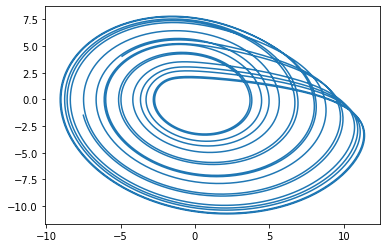

In [513]:
plt.plot(traj[0], traj[1])

In [311]:

model =  Rossler()
number_of_positions = 10




initial_sol = model.make_trajectory(1000, method="Radau", resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[1]), number_of_positions, replace=False)
sample_pts = initial_sol[:, sample_inds].T

all_initial_points = np.hstack([make_epsilon_ball(pt, 100) for pt in sample_pts])


model.ic = all_initial_points.T
tpts, traj_ball = model.make_trajectory(200, method="Radau", resample=True, pts_per_period=30, return_times=True)

traj_ball_expanded = np.stack(np.array_split(traj_ball, number_of_positions))

In [83]:
traj_ball_expanded = np.stack(np.array_split(traj_ball, number_of_positions))

In [228]:
sample_inds = np.random.choice(np.arange(initial_sol.shape[1]), 200, replace=False)
sample_pts = initial_sol[:, sample_inds].T

In [56]:
sample_pts = initial_sol[:, sample_inds, :]

In [24]:
def make_diverging_trajectory(model, m=100, n=1000, number_of_positions=30, points_per_position=100):
    """
    
    Args:
        points_per_position (int): the number of points to use to estimate the exponents at each position
        
    """
    
    ## Select a set of initial conditions
    model.make_trajectory(1000, method="Radau", resample=True, pts_per_period=30)
    initial_sol = eq.make_trajectory(1000, method="Radau", resample=True, pts_per_period=30)
    sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), number_of_positions, replace=False)
    sample_pts = initial_sol[:, sample_inds].T
    
    all_ic = list()
    for pt in sample_pts:
        all_ic.append(make_epsilon_ball(pt, points_per_position))
    all_ic = np.array(all_ic)
    

    

def find_max_lyapunov(traj1, traj2, dt=1.0, return_error=False):
    """
    Given two diverging trajectories (or batches of diverging trajectories), 
    calculate the maximum lyapunov exponent by fitting an exponential
    
    Args:
        traj1 (ndarray): A batch of trajectories (B, T, D) or a single trajectory (T, D)
        traj2 (ndarray): Same as above
        dt (float): the timestep
        
    Returns:
        lyap (float): the lyapunov exponent
    
    """
    traj_differences = np.sum((traj1 - traj2)**2, axis=-1)
    if len(traj_differences.shape) == 1:
        traj_differences = traj_differences[None, ...]
    print(traj_differences.shape)
    lyapunov_estimates = list()
    for item in traj_differences :
        p = np.polyfit(np.arange(len(item)), np.log(item), 1)
        lyapunov_estimates.append(p[0] / dt)
        
    if not return_error:
        return np.mean(lyapunov_estimates)
    else:
        return np.mean(lyapunov_estimates), np.std(lyapunov_estimates)
    
# find_max_lyapunov(reference_sol, perturbed_sol)

In [32]:
# difference_vector = (reference_sol - perturbed_sol)



In [292]:
del eq

0.11724657837664709
0.091538689611144
0.0747938103348513
0.10210668052562039
0.07792294157046326
0.0756377237311469
0.09588256276009974
0.09245191638402186
0.11921422066892312
0.06007677109096802
0.0765486563577143
0.08807025340391805
0.11397719729595215
0.09718435857359387
0.08793920685477627
0.07512608670968228
0.10851936689085082
0.10103748883790843
0.08035874127109167
0.1082608742453971
0.11134593024239639
0.07667330343320244
0.09706534746412329
0.09791770106346652
0.07635269375453792
0.06839459377435295
0.06198221233437269
0.08738636810402822
0.056973163187860575
0.0924723037986079
0.08663658504524836
0.08248745636092729
0.09816441542032049
0.11130613473893385
0.12252211899992854
0.11859019363156889
0.11055232660157097
0.09622489186901509
0.06595744195946696
0.1033357217523389
0.10932854491389095
0.07901226629889209
0.10443147664773103
0.09352210711768173
0.09860683136695748
0.05918570189080563
0.10310295289817363
0.1136739828695531
0.10805441062123615
0.04417025224641917
median 0

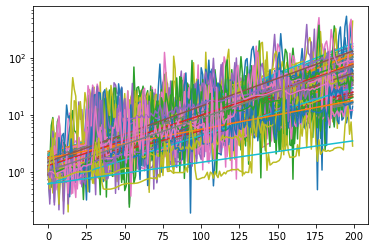

In [22]:
## Test the simple stretching lyapunov code

import scipy
from scipy.optimize import curve_fit

model = Lorenz() # λ1 = 2.0686, λ2 = −0.0115, λ3 = −32.3537
model.sigma = 16
model.rho = 45.92
model.beta = 4.0


model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
model.a = 0.15
model.b = 0.2
model.c = 10


# model = Rossler()
# model.a = 0.15
# model.c = 10
m = 50
# sol = eq.make_trajectory(10000, method="Radau", resample=True, pts_per_period=30)

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), m, replace=False)
sample_pts = initial_sol[:, sample_inds].T

model.ic = sample_pts
tpts, reference_sol = model.make_trajectory(200, method="Radau", resample=True, pts_per_period=30, return_times=True)
model.ic = sample_pts * (1 + 1e-5)
tpts, perturbed_sol = model.make_trajectory(200, method="Radau", resample=True, pts_per_period=30, return_times=True)

errs_sol = np.sqrt(np.sum((reference_sol - perturbed_sol)**2, axis=-1))
errs_sol /= errs_sol[:, 0][:, None]



# def exponential(x, a, k):
#     return a * np.exp(k * x)

all_m = list()
for item in errs_sol:
    plt.semilogy(item)
#     popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, np.arange(len(item)), item, p0=[1.0, 0.1])
#     plt.semilogy(np.arange(len(item)), exponential(np.arange(len(item)), *popt_exponential))
    
    ## Need to fetch time vals because of resampling
    
    p = np.polyfit(np.arange(len(item)), np.log(item), 1)
    poly = np.poly1d(p)
    plt.semilogy(np.arange(len(item)), np.exp(poly(np.arange(len(item)))))
    
    dtval = np.median(np.diff(tpts))
    lyap = p[0] / dtval
    print(lyap)
    
    all_m.append(lyap)
    
print("median", np.median(all_m))

In [11]:
print(np.median(all_m))

1.193858565686893


In [25]:
## Find and write Lyapunov exponents of each attractor

from nolds import lyap_r

# We will make a local copy of the internal database
path_output = "./chaotic_attractors2.json"

total_length = 500

with open("thom/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))

for i, item in enumerate(list(data.keys())):
    
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length, method="Radau", resample=True, pts_per_period=30)
    
    print(item, [lyap_r(item) for item in sol])
    
    
#     data[item]["period"] = signif(period, 5)
#     print(item, " time period", period," index period", period/eq.dt, " ", (1/eq.dt)/period)
    
# with open(path_output, 'w') as f:
#     json.dump(data, f, indent=4)

113


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


Lorenz [0.041520305325214175, 0.05030395715756524, 0.002049667299732009]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


LorenzBounded [0.0423000859138661, 0.044693010193961054, 0.02393847786381157]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: s

LorenzCoupled [0.047665801084131244, 0.05192117942006962, 0.017020549354972443, 0.037983585210671106, 0.009941328386838547, -0.021754444863360672]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Lorenz84 [0.057068215662095315, 0.08058682794549635, 0.08688518037648407]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Lorenz96 [0.03410654847783252, 0.03781151502652277, 0.029924379165907587, 0.03368810988906632]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Thomas [0.037537907030349385, 0.04201173589641887, 0.03938897866055481]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

ThomasLabyrinth [0.004560366852470462, 0.012676187609702672, 0.021972162949686787]
HenonHeiles [0.005855111430462135, 0.00834445361804245, 0.004446895498978437, 0.006531019139110621]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Chua [0.09306242255059846, 0.09638147878467584, 0.11436217107803076]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


MultiChua [0.0387559821317483, 0.003416013359127162, 0.003145610748377058]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelati

JerkCircuit [0.02160009800043321, 0.027968556002566678, 0.04950363828723592]
Colpitts [0.0007047077951670196, 0.011581898811168242, 0.015578241662664687]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:45: RuntimeWarning: RA

Duffing [-0.008884701782599426, 0.005155558424784722, -1.2766361424485913e-16]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

Torus [-0.007387084490039601, 0.008699257393344727, 0.001437438653841595]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Halvorsen [0.02168124779722747, 0.02449055040689339, 0.017564668969713322]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

MooreSpiegel [0.029655588367827855, 0.055896360892102225, 0.057279221993639946]
Bouali2 [-0.007212022417470044, 0.01319348030065115, 0.0017358668764730649]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: s

Bouali [0.012020444260689161, 0.0014425999549141095, 0.016236671133148937]
Arneodo [0.00607405602931978, 0.02295420302036113, 0.024757930894095205]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coullet [0.006625423485175111, 0.017526233644413754, 0.021323099978884364]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


Rucklidge [0.04220813302169169, 0.03838637269529184, -0.006373547538262915]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

BurkeShaw [0.04039350278759585, 0.03922950840884246, 0.03811533968559557]
ZhouChen [0.07122521207744915, 0.000626884042260501, 0.04203058730114943]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


LuChenCheng [0.008385051237909426, 0.012000034648672983, -0.003079599202663827]
Chen [0.02861560529335996, 0.028918415980231503, 0.00797076104318019]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: s

ChenLee [0.018033845330539512, 0.020774702738998542, 0.006703300031178819]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


LuChen [0.03776397794709171, 0.03728573349185455, 0.0014110064987490128]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


QiChen [0.04884251257530734, 0.046020462907346536, 0.0034458832999769407]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: s

YuWang [0.04738469838647913, 0.061263927167519584, 0.00973069118289091]
YuWang2 [0.009261902452978183, 0.012686447256266595, -0.0060393969381125]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: s

NewtonLiepnik [0.033374977470340544, 0.03829940458885706, -0.003480293821630462]
DequanLi [-0.0007612319977000222, 0.001991569906249131, -0.000501028959416094]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


Tsucs2 [0.026032932091476318, 0.02639386411896322, 0.0019134310974324893]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

ArnoldWeb [0.028104735992767086, 0.03045970076447609, 9.73561652621297e-05, -0.0001089508372141031, -1.0905488268105643e-16]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


PanXuZhou [0.02428350125936644, 0.030269925217879474, 0.009332612925723946]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


WangSun [0.04553529865675626, 0.02277458536623131, 0.07787288746908586]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/thom/base.py:133: UserWarning: Excessive integration required; scale factor 1801.8431108114187
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


Sakarya [0.04525331644187299, 0.05343521985792574, 0.03274326190016324]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

LiuChen [0.036910920214832325, 0.21857220451894716, 0.2525056194542045]
Aizawa [0.007301286225095491, 0.007232814704738868, 0.010604669501010633]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


SanUmSrisuchinwong [0.03551734646080285, 0.0405301072543725, 0.035044010637040914]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Finance [0.04560046275190069, 0.025614847461660404, 0.04901365071983265]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Dadras [0.02695718303026305, 0.03961922400876095, 0.07898189816483878]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelati

RikitakeDynamo [0.016181751547899477, 0.018533311811576882, 0.015358237593021073]
RabinovichFabrikant [0.033934795614946014, 0.015035827541933909, 0.014138668827208949]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

AnishchenkoAstakhov [0.008109574210374861, 0.008075084161937689, -0.003771615915990564]
GenesioTesi [0.014037217816015825, 0.014027748161688787, 0.018873152607365662]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelati

ShimizuMorioka [0.022146624998938762, 0.043710313076363486, 0.01019901176125317]
SprottTorus [-0.004264978791190677, 0.08377349242231896, 0.011623541279205757]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


SprottJerk [0.01184305328844269, 0.020407480897760042, 0.02724492854641792]
SprottB [0.04838616509634748, 0.03832868523615643, 0.03633181446028831]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

SprottC [0.032967338042466765, 0.015529020131946021, 0.0428221380128]
SprottD [0.008292299744592604, 0.016218629344961696, -0.014972081551185092]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


SprottE [0.047374623879454195, 0.03057619366878853, 0.032245610105363955]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


SprottF [0.053566497722570605, 0.043658044583451246, 0.01754736518367009]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


SprottG [0.013190625574355682, 0.012870138569882027, 0.015051926795701318]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

SprottH [0.05431403757976296, 0.042526172195330156, 0.05176570637753805]
SprottI [-0.004637386745080065, -0.0036489015235040617, -0.003680469039687514]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

SprottJ [0.006042515200779854, 0.0069227685605672985, 0.006776705401060277]
SprottK [0.003974298337348419, 0.0001612737938598006, 0.0016009865846848845]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: s

SprottL [0.02074106738979655, -0.006525379829891383, 0.0067924285069444115]
SprottM [0.02230833107815648, -0.016729141341555728, 0.02524897729543814]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

SprottN [-0.0001862156936235896, -0.0006830905164991436, -0.0007785953973469093]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

SprottO [0.010389567897784776, 0.005688218484845161, 0.006558401961075633]
SprottP [0.019284966162272855, 0.019975133049756937, 0.014474857704980025]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


SprottQ [0.017955195253953, 0.01653394452051112, 0.013334181501453076]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

SprottR [0.0016381119303904952, 0.0038835214941125113, 0.007164748853310594]
SprottS [0.018065382596245377, 0.021382912612499146, 0.01897860722882407]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Hadley [0.008952037284248749, 0.02266818159504941, 0.019326473044273547]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


RayleighBenard [0.027681120176960658, 0.026928035477946564, -0.012613947549114412]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


NoseHoover [0.01333906899269362, 0.031859143380831956, 0.021287608818900315]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: a

KawczynskiStrizhak [0.007876385920361096, -0.012629249593713813, -0.004960908869079967]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


VallisElNino [0.029196411147153482, 0.03330381884610745, 0.023509408656815813]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

DoublePendulum [0.015603151391534164, 0.005160113384848954, 0.023827179691247737, 0.047837070056370314]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: s

SwingingAtwood [-0.0065736998529995015, 0.009429494330757524, 0.009935469466044464, 0.005398851946780507]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:45: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  warnings.warn(


FluidTrampoline [0.011245839398606378, 0.018124333897927662, -5.886394792775286e-17]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:45: RuntimeWarning: RA

DoubleGyre [0.005326570164073603, 0.0007643316095886008, -1.3578886217607056e-16]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


BlinkingRotlet [0.00767371460396539, 0.01728966863531805]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


BlinkingVortex [0.012440174599380613, 0.003042511473920998]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: a

OscillatingFlow [-0.005745218212443198, 0.010088803348779004, -1.5861942264080584e-16]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

BickleyJet [0.001247590538789477, -9.130535269132124e-06, -2.6828120992280796e-16]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

ArnoldBeltramiChildress [0.002433925762510884, 0.013712154354965275, -0.00263465440320416]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: a

BelousovZhabotinsky [0.006963346029065421, 0.011945424223304635, 0.012099781968539695]
IsothermalChemical [0.02225950275148658, 0.001856010425912363, 0.02503481081553858]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

ForcedBrusselator [0.002736243043844704, 0.02813204618600704, -1.9391828308147195e-16]
ForcedVanDerPol [-0.017007323411794856, 0.0975218771338897, -5.198600668269196e-09]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:45: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find 

StickSlipOscillator [-0.001839517650747665, 0.0003214318701562138, -2.7131969089372016e-17]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:45: RuntimeWarning: RA

ForcedFitzHughNagumo [0.003917529250812996, 0.0012092100017745404, -2.1342878143689645e-17]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


HindmarshRose [0.010042463926444353, -0.023802770267833454, 0.009285978804853606]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

CellCycle [-0.004593527251547492, 0.002933821931083403, -0.002106485562724656, 0.04364863590343849, 0.03769753539300228, 0.0008246309024911435]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

CircadianRhythm [0.007324041869572327, 0.005411075182029501, -0.0013369435765271975, 0.004504079490734601, 1.7209160463100008e-08]
CaTwoPlus [0.005809214088943011, -0.0008126471068832353, 0.005900905682490572]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

CaTwoPlusQuasiperiodic [0.00785457219310748, 0.009981284822736506, -0.00041886076285937524]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


ExcitableCell [0.00017717418137117128, 0.00938923467289321, 0.008749438183648208]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


ItikBanksTumor [0.046475989388343936, 0.003630316701659095, 0.04080237150192258]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Laser [0.04424156504017967, 0.048367292943753706, 0.008655968002604906]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

WindmiReduced [0.009053146401547018, 0.03228781059928904, 0.008898807202237494]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


TurchinHanski [0.0010407640383793802, -0.004656474559210633, -8.037880678147259e-09]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

Blasius [0.0011848158888764064, 0.013178704899547302, 0.018273673380227947]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runtim

HastingsPowell [0.002260535661771058, 0.013052606443667186, -0.00937651363866671]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

SaltonSea [0.0006772840566927106, 0.013110527430130534, 0.029395775284086052]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: a

CoevolvingPredatorPrey [0.02091688489049216, 0.008586321771144859, -0.002080768303532021]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

MacArthur [0.0020108428494684, -0.0034786685454799393, 0.01105496439709507, -0.0042519105308275445, 0.015362739770549274, 0.02055459293253692, 0.0021726438996432515, 0.006609803941369287, 0.006925301118330478, -0.004645185353219126]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


BeerRNN [0.01196102095391471, -0.004175625049351346, -0.002995166697340281]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


CellularNeuralNetwork [0.01530430864234616, 0.01651222405577064, 0.015572910380542712]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has ve

Hopfield [0.028552266439997157, 0.023908845441681967, 0.022535466834118494, 0.023790213308836274, 0.02538878070680718, 0.030063200489918965]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

MackeyGlass [0.006033930540560767, 0.008058769276544841, 0.011780106009817694]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 120
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 120
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 120
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


IkedaDelay [0.011920879364351707, 0.015723728122500787, 0.01006215679027682]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: Runti

SprottDelay [0.0008691875671053555, -0.000663938427295977, -0.005178574223149829]
VossDelay [0.008810174129063016, 0.000967763976066135, 0.010787064483115718]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


ScrollDelay [0.01510558823207603, 0.017825402941246675, 0.01930453080992053]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


PiecewiseCircuit [0.06718038652736441, 0.06719309769962964, 0.06726942819760258]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelati

HyperRossler [0.019646490785412325, 0.023690375528837536, 0.011672590058166633, 0.009314395079794853]
Rossler [0.015663199496448503, 0.01642167783321294, 0.015864653369965193]


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


## Find and write period of each attractor
+ Expressed in units of dt

In [18]:
# We will make a local copy of the internal database
path_output = "./chaotic_attractors2.json"


total_length = 40000*100

total_length = 500000

with open("thom/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))

for i, item in enumerate(list(data.keys())):
    
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length, method="Radau")
    
    all_freqs = list()
    for comp in sol:
        try:
            freqs, amps = find_significant_frequencies(comp, return_amplitudes=True, significance_threshold=0.95)
            max_freq = freqs[np.argmax(np.abs(amps))]
        except:
            ## ignores time-like coordinates
            continue
        all_freqs.append(max_freq)
        print(".", end='')
    period = eq.dt * (1 / np.median(all_freqs))
    
#     freqs, amps = find_significant_frequencies(sol[0], return_amplitudes=True, significance_threshold=0.95)
#     max_freq = freqs[np.argmax(np.abs(amps))]
#     period = (1/max_freq) * eq.dt
    
    #period = np.median([1/freq_from_fft(item) * eq.dt for item in sol])
    
    data[item]["period"] = signif(period, 5)
    print(item, " time period", period," index period", period/eq.dt, " ", (1/eq.dt)/period)
    
with open(path_output, 'w') as f:
    json.dump(data, f, indent=4)

106
...Lorenz  time period 1.5008333333333332  index period 8333.333333333334   3699.5919041830366
...LorenzBounded  time period 1.3715789473684208  index period 5263.157894736842   2797.7234188297984
......LorenzCoupled  time period 1.620720720720721  index period 9009.00900900901   3429.7356847930764
...Lorenz84  time period 6.258620689655172  index period 17241.379310344826   440.16422679082336
....Lorenz96  time period 2.1969230769230768  index period 15384.615384615383   3187.549529615768
...Thomas  time period 4.968965517241379  index period 17241.379310344826   698.2967819113202
...ThomasLabyrinth  time period 6.05  index period 17241.379310344826   471.0437623207384
....HenonHeiles  time period 6.37  index period 2500.0   61.61140944724708
...Chua  time period 11.387931034482756  index period 17241.379310344826   132.94816568779763
...MultiChua  time period 2.258630952380952  index period 2976.1904761904757   583.4050334067967


/Users/williamgilpin/program_repos/thom/thom/thom.py:264: RuntimeWarning: overflow encountered in exp
  zdot = -z - x  - self.eps*(np.exp(y/self.y0) - 1)


...JerkCircuit  time period 9.727272727272728  index period 6493.506493506495   68.62732865003805
...Colpitts  time period 4.267592592592592  index period 9259.25925925926   508.40561598024306
..Duffing  time period 7.449579831932774  index period 4201.680672268908   75.71108776155715
...Torus  time period 6.36  index period 16666.666666666668   412.0353888954814
...Halvorsen  time period 1.488888888888889  index period 6944.444444444444   3132.657607484963
...MooreSpiegel  time period 1.288709677419355  index period 8064.5161290322585   4855.8821179791385
...Bouali2  time period 2.677922077922078  index period 6493.506493506493   905.4894770363165
...Bouali  time period 3.041095890410959  index period 6849.315068493151   740.6054703352
...Arneodo  time period 3.1640624999999996  index period 2604.1666666666665   260.12294873748925
...Coullet  time period 5.766331658291457  index period 2512.5628140703516   75.56447899905544
...Rucklidge  time period 6.0721311475409845  index period 81

/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:307: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:337: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


..BickleyJet  time period 86956.52173913043  index period 869.5652173913044   1.1500000000000001e-07
...ArnoldBeltramiChildress  time period 161.97727272727272  index period 22727.272727272728   0.8662418446037338


/Users/williamgilpin/program_repos/thom/thom/thom.py:313: RuntimeWarning: invalid value encountered in sqrt
  rf = (self.ci - self.z0*z)*np.sqrt(x)


...BelousovZhabotinsky  time period 0.018257142857142857  index period 23809.52380952381   71430728.92813906
...IsothermalChemical  time period 0.7678448275862069  index period 8620.689655172413   14621.606254286195
..ForcedBrusselator  time period 20.410526315789472  index period 10526.315789473683   25.267832373731988
..ForcedVanDerPol  time period 2.3163398692810455  index period 6535.9477124183   1218.1590734220304
..StickSlipOscillator  time period 1.6129032258064515  index period 16129.032258064515   6200.0
..ForcedFitzHughNagumo  time period 35.80357142857143  index period 17857.14285714286   13.930261627726196
...HindmarshRose  time period 1.7519565217391304  index period 21739.130434782608   7082.645745721839
......CellCycle  time period 204.70873786407765  index period 4854.368932038835   0.11584039195889985
....CircadianRhythm  time period 27.0  index period 15625.0   21.43347050754458
...CaTwoPlus  time period 1.3429824561403507  index period 8771.929824561403   4863.562149

In [ ]:
# Find the number of integration timepoints per period

import thom

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

for item in list(data.keys())[:10]:
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*2000)
#     sol = eq.make_trajectory(50000)
    
    plt.plot(np.linspace(0, 1, len(sol[0])), sol[0])
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

## Plot attractors with matching dominant timescales

+ This does not look great, because the sub-leading timescales are clearly more important for some attractors

54226
82329
8698
103244
2807
10818
5741
1251
9800
103575


/Users/williamgilpin/program_repos/thom/thom/thom.py:264: RuntimeWarning: overflow encountered in exp
  zdot = -z - x  - self.eps*(np.exp(y/self.y0) - 1)


432
86205
1062
102916
26910
819
22441
13451
103295
2677


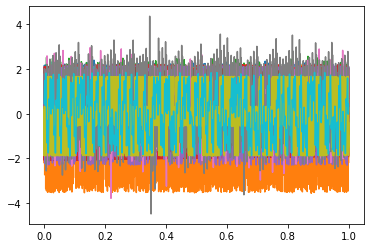

In [3]:
# Find the number of integration timepoints per period

import thom

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

all_attractors = get_attractor_list()

for item in all_attractors[:20]:
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length, method="Radau", resample=False)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*200)
#     sol = eq.make_trajectory(50000)
    
    samp = sol[0]
    samp = (samp - np.mean(samp)) / np.std(samp)
    plt.plot(np.linspace(0, 1, len(sol[0])), samp)
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

YuWang
YuWang2
ZhouChen


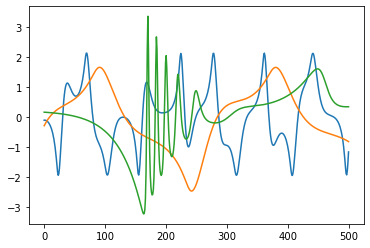

In [49]:
# Find the number of integration timepoints per period

import thom

transient_fraction = 0.1
total_length = 500

all_attractors = get_attractor_list()

for item in all_attractors[110:]:
    print(item)
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length, method="Radau", resample=True)
    
    
#     freq_ceiling = np.max(find_significant_frequencies(sol[0]))
#     freq_dominant = freq_from_fft(sol[0])
    
#     timepoints_per_cycle = int(freq_ceiling/freq_dominant)
#     print(timepoints_per_cycle)
    
#     sol = eq.make_trajectory(total_length)
#     sol = eq.make_trajectory(50000)
    
    samp = sol[0]
    samp = (samp - np.mean(samp)) / np.std(samp)
    plt.plot(samp)
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    
# plt.gca().legend()

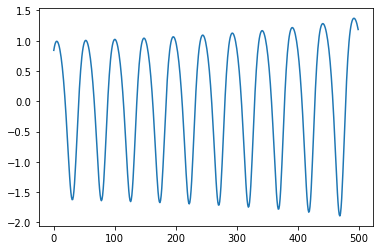

In [43]:
all_attractors = get_attractor_list()

eq = getattr(thom, all_attractors[50])()

eq = getattr(thom, "PanXuZhou")()
# eq.period *= 0.15
# eq = getattr(thom, "Lorenz")()
sol = eq.make_trajectory(total_length, method="Radau", resample=True)

samp = sol[0]
samp = (samp - np.mean(samp)) / np.std(samp)
plt.plot(samp)

In [27]:

# insert a control function that takes the current values of all vars and adds forcing

# various functions for sampling from each system, and removing transients

# function that goes to numba

# function that couples attractors together (can use slaving to force chaos)

In [ ]:
#https://stackoverflow.com/questions/1796180/how-can-i-get-a-list-of-all-classes-within-current-module-in-python

In [ ]:
## Some day have an API working

import inspect


def generate_data(model, n_samples, params, frac_perturb_param=.1, 
                             n_classes=2, frac_transient=0.1, 
                             ic_range=None,
                            random_state=0):
    """
    Generate an ensemble of trajectories with random initial conditions, labelled by different
    sets of parameters.

    model : an instantiation of a dynamical system
    tpts : the timesteps over which to run the simulation
    params : iterable, the starting values for the parameters
    n_samples : int, the number of different initial conditons
    n_classes : int , the number of different parameters
    frac_perturb_param : float, the amount to perturb the parameters by
    frac_transient : float, the fraction of time for the time series to settle onto the attractor
    ic_range : a starting value for the initial conditions
    random_state : int, the seed for the random number generator
    """

    num_per_class = int(n_samples/n_classes)

    params = inspect.getfullargspec(model.__init__).defaults # get default values of params
    
    params = model.get_params()

    param_fractional_perturb = frac_perturb*2*(np.random(len(model.default_params)) - 0.5)
    params = model.default_params*param_fractional_perturb

    mod = model(*params)
    
    
    
    
    np.random.seed(random_state)
    
    ntpts = len(tpts0)
    dt = tpts0[1] - tpts0[0]
    t_range = tpts0[-1] - tpts0[0]
    tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
    all_params = list()
    all_samples = list()
    for i in range(n_classes):
    
        params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
        params_prime = params*params_perturb
        all_params.append(params_prime)
    
        eq = Lorenz(*params_prime)
        
        all_samples_per_class = list()
        for j in range(num_per_class):
            ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
            sol = integrate_dyn(eq, ic_prime, tpts)
            
            all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
        all_samples.append(all_samples_per_class)
    
    all_samples, all_params = np.array(all_samples), np.array(all_params)
    return all_samples, all_params

In [ ]:
model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
model.sigma = 16
model.rho = 45.92
model.beta = 4.0
model.dt = 1e-4

# model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# model.dt = 1e-3

points_to_sample = 20 # number of points to sample in ensemble
pts_to_estimate_jacobian = 200
pts_per_trajectory = 1000 # number of timesteps to use to find the jacobian
pred_step = 1

lyap_list = list()

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), points_to_sample, replace=False)
sample_pts = initial_sol[:, sample_inds].T
d = initial_sol.shape[0]
print("Finished selecting initial points on attractor.")

# analytic jacobian for lorenz
def jac(X, t, model):
    x, y, z = X
    return np.array([[-model.sigma, model.sigma, 0], [model.rho - z, -1, -x], [y, x, -model.beta]])

jac(initial_sol[:, -1], 0, model)

all_estimates_lyap = list()
for j, sample_pt in enumerate(sample_pts):
    if j % 5 == 0: print(j)
        

#     model.ic = sample_pt
#     model.ic = make_epsilon_ball(model.ic, pts_to_estimate_jacobian, eps=1e-8).T
#     tpts, traj_ball = model.make_trajectory(pts_per_trajectory, pts_per_period=80, 
#                                             resample=True, return_times=True)
#     dt = np.median(np.diff(tpts))
#     traj_ball -= np.mean(traj_ball, axis=0) # subtract center of ball
    
    curr = sample_pt
    
    old_Q = np.identity(d)
    lexp = np.zeros(d)
    lexp_counts = np.zeros(lexp.shape)
    for i in range(pred_step, pts_per_trajectory): # number of timepoints

        x0 = make_epsilon_ball(curr, pts_to_estimate_jacobian, eps=1e-5).T
        y0 = x0 + np.vstack(model.rhs(x0, 0)).T * model.dt
        x = x0 - np.mean(x0, axis=0)
        y = y0 - np.mean(y0, axis=0)
        curr = model.make_trajectory(2, resample=False)[:, -1]
            
        
            
#         x = traj_ball[:, i - pred_step]
#         y = traj_ball[:, i]
        
        
        xinv = np.linalg.pinv(x.T)
        tm = np.dot(y.T, xinv)
        
        
        tm = jac(curr, 0, model)
        
        
        mat_T = tm
        # QR-decomposition of T * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(mat_T, old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)

        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape)
        lexp_i[idx] = np.log(diag_R[idx])
        lexp_i[np.where(diag_R == 0)] = np.inf
#         if debug_plot or debug_data:
#             debug_values.append(lexp_i / tau / m)
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

    
     # normalize exponents over number of individual mat_Rs
    idx = np.where(lexp_counts > 0)
    lexp[idx] /= lexp_counts[idx]
    lexp[np.where(lexp_counts == 0)] = np.inf
    # normalize with respect to timestep (also and number of steps?)
    lexp /= (pred_step * dt)
    all_estimates_lyap.append(lexp)
    
#     print(lexp)
    print("\nCurrent Median Estimate: ", np.median(np.array(all_estimates_lyap), axis=0))
    
  
print("\nFinal Estimate: ", np.median(np.array(all_estimates_lyap), axis=0))

#     traj_ball -= np.mean(traj_ball, axis=0, keepdims=True)

#     cov = np.einsum("kim,kin->imn", traj_ball, traj_ball) / (traj_ball.shape[0] - 1)
#     eigs, vecs = np.linalg.eigh(cov)
#     rads = np.sqrt(eigs)
#     rads /= rads[0, :][None, :]

#     assert np.all(np.diff(np.argsort(eigs, axis=1), axis=1) == 1), "Eigenvalues are not sorted; please report this bug."

#     xinds = np.tile(np.arange(eigs.shape[0]), (eigs.shape[1], 1))

#     # rads = np.sqrt(np.sum((traj_ball[[1, 2, 9]] - traj_ball[[3, 4, 8]])**2, axis=-1).T)
#     # rads /= rads[0, :][None, :]

    
#     all_lyap = find_slope(xinds, np.log(rads.T)) / dt

#     print(all_lyap)
    
#     lyap_list.append(all_lyap)
    
# print("\nFinal estimate: ", np.median(np.array(lyap_list), axis=0)[::-1])    

# p = np.polyfit(np.arange(len(item)), np.log(item), 1)
# poly = np.poly1d(p)

# cov = np.cov(x_std.T)
# ev , eig = np.linalg.eig(cov)
# a = eig.dot(x_std.T)
